In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data_uniform=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz",allow_pickle=True)
data_gauss=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)
data_gauss_5=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)

In [2]:
data_uniform=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz",allow_pickle=True)
data_gauss=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)
data_gauss_5=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_11_18_sample_100x100x5mm_no_defect_isotropic_gaussian_heat_no_conv_cond_5.npz",allow_pickle=True)

In [3]:
data_uniform['meta']

array([['time', '24/10/2025 20:16:11'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '300'],
       ['T2_units', 'frames'],
       ['T3', '3000'],
       ['T3_units', 'frames'],
       ['fps', '300.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '3304'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J

In [4]:
ccase=torch.from_numpy(data_uniform['data']).to(torch.float32)

In [5]:
ccase.size()

torch.Size([3304, 512, 512])

In [ ]:
class DataGenerator:
    def __init__(self,data):
        self.data=data
    
    def get_indexes_latin(self, n_points):
        """
        Generate n_points unique 2D integer indices on a grid (size_y, size_x)
        using true stratified sampling (2D Latin Hypercube style),
        strictly inside the boundaries (not touching edges).
        """

        size_y = self.data.size(1)
        size_x = self.data.size(2)

        # Determine number of strata along each axis (roughly square)
        n_sqrt = int(torch.ceil(torch.sqrt(torch.tensor(n_points, dtype=torch.float32))))
        n_y = min(n_sqrt, size_y - 2)  # leave 1 pixel margin
        n_x = min(int(torch.ceil(torch.tensor(n_points, dtype=torch.float32) / n_y)), size_x - 2)

        # Compute stratum edges (avoid touching boundaries)
        y_edges = torch.linspace(1, size_y - 1, n_y + 1)
        x_edges = torch.linspace(1, size_x - 1, n_x + 1)

        points = []
        for i in range(n_y):
            for j in range(n_x):
                if len(points) >= n_points:
                    break

                # Pick a random point inside the stratum
                y = torch.randint(int(y_edges[i]), int(y_edges[i + 1]), (1,)).item()
                x = torch.randint(int(x_edges[j]), int(x_edges[j + 1]), (1,)).item()

                points.append((y, x))

        # Convert to tensors
        points = torch.tensor(points[:n_points])
        Y, X = points[:, 0], points[:, 1]

        return X, Y

    
    def sub_sample(self,X,Y,sub_sample=1,frame_rate=300):
        T=self.data.size(0)
        temp=self.data[::sub_sample,Y,X]
        temp_len=temp.size(0)
        t_v=torch.linspace(0,T/frame_rate,temp_len) # This produce for us only physical scale of time
        return temp, t_v
    
    def network_format(self,n_points,sub_sample=1,frame_rate=300,phys_scale=0.1):
        # 1. Get the sample points
        X, Y = self.get_indexes_latin(n_points)

        # 2. Sample the data
        temp, t_v = self.sub_sample(X, Y, sub_sample, frame_rate)  # temp shape: (T, n_points)
        T = temp.size(0)

        # 3. Convert indices to physical units for network 
        # Debugging line
        # Yf = Y.to(torch.float32)
        # Xf = X.to(torch.float32)
        
        _,N_y,N_x=self.data.size()
        Yf = Y*phys_scale/N_y
        Xf = X*phys_scale/N_x

        # 4. Use meshgrid over time and point index
        point_idx = torch.arange(n_points).to(torch.float32)
        
        # Debugging line
        # t_v=torch.linspace(0,3304,3304)

        Tt, P = torch.meshgrid(t_v, point_idx, indexing='ij')  # shape: (T, n_points)
        P = P.to(torch.long)  # index must be integer

        # 5. Gather corresponding Y, X for each point
        Yy = Yf[P]  # shape: (T, n_points)
        Xx = Xf[P]  # shape: (T, n_points)

        # 6. Flatten in row-major order to match temp.flatten()
        Tt = Tt.reshape(-1, 1)
        Yy = Yy.reshape(-1, 1)
        Xx = Xx.reshape(-1, 1)
        Zz = torch.zeros_like(Xx)

        # 7. Network input
        X_net = torch.cat([Tt, Yy, Xx, Zz], dim=1)

        # 8. Flatten target in **same order**
        Y_net = temp.reshape(-1, 1)


        # Our X_net data are in physical unit sense
        return X_net, Y_net

    def boundary_data(self,boundary_division):
        
        

In [7]:
operator=DataGenerator(ccase)

In [8]:
X,Y=operator.network_format(30)

In [47]:
x=torch.linspace(0,511,4)
y=torch.linspace(0,511,4)

P_lr=torch.ones(8,2)*511
P_lr[0:4,0]=0.0
j=0
for i in range(8):
    if j==4:
        j=0
    P_lr[i,1]=x[j]
    j=j+1

P_tb=torch.ones(8,2)*511
P_tb[0:4,1]=0.0

j=0
for i in range(8):
    if j==4:
        j=0
    P_tb[i,0]=y[j]
    j=j+1

P=torch.concatenate([P_lr,P_tb],dim=0)
P=P.round()
P

tensor([[  0.,   0.],
        [  0., 170.],
        [  0., 341.],
        [  0., 511.],
        [511.,   0.],
        [511., 170.],
        [511., 341.],
        [511., 511.],
        [  0.,   0.],
        [170.,   0.],
        [341.,   0.],
        [511.,   0.],
        [  0., 511.],
        [170., 511.],
        [341., 511.],
        [511., 511.]])

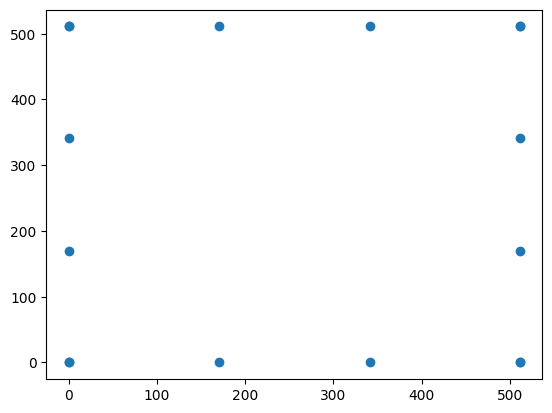

In [48]:
plt.scatter(P[:,0],P[:,1])